<a href="https://colab.research.google.com/github/StefanMalv/INFO284_SemesterOppgave_2025V/blob/main/Oppgave1/16_04_2025_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()  # Manually upload "Hotel_Reviews.csv"

Saving Hotel_Reviews.csv to Hotel_Reviews.csv


We begin by uploading the 'hotel_reviews.csv' file manually via Google Colab. This step is required for access to the review dataset.


In [2]:
!pip install nltk


This combination of importing libraries supports all steps: preprocessing, vectorization, model training, and evaluation.
(spørsmål: er det best å forklare hvorfor vi har valgt å import med kmt i koden sånn som over. eller burde jeg skrive det her som en markdown)

In [3]:
### Importing Libraries

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [4]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

We download essential linguistic resources. These are required for effective text normalization later on.


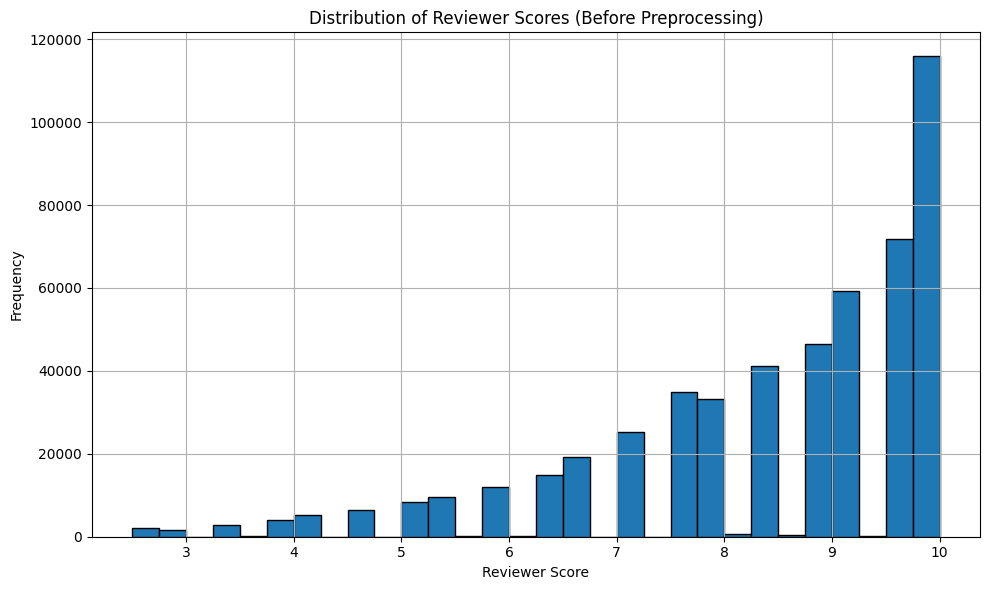

In [5]:
#Load the dataframe before using it
df = pd.read_csv("Hotel_Reviews.csv")

plt.figure(figsize=(10, 6))
df["Reviewer_Score"].hist(bins=30, edgecolor="black")
plt.title("Distribution of Reviewer Scores (Before Preprocessing)")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

We visualize the distribution of the 'Reviewer_Score'. This step helps us understand how user scores are distributed before any transformations, and we get insight to choose meaningful variables later on. f.eks most scores are above 8, witch is important insight to difine "bad rewies"



In [6]:
#Load and combine reviews
df = pd.read_csv("Hotel_Reviews.csv")
df["Positive_Review"] = df["Positive_Review"].astype(str)
df["Negative_Review"] = df["Negative_Review"].astype(str)
df["reviews"] = df["Positive_Review"] + " " + df["Negative_Review"]

We cast both the 'Positive_review' and 'Negative_review' columns to strings and then concatenate them into a single `review' column. Combining both perspectives into one sentence helps the model learn the overall sentiment of the user experience.
(spørsmål: er det dumt å ha stor bokstav på Posetiv og Negativ og så liten på reviews)


In [7]:
#Create label for bad reviews (score <= 8) BEFORE selecting specific columns
#Most scores are above 8, so using 8 as the threshold helps capture truly negative reviews and keeps the classes balanced.
df["Bad_reviews"] = df["Reviewer_Score"].apply(lambda x: 1 if x <= 8 else 0)

We define binary labels in the `Bad_reviews'column, before selcting specific columns:
- 1 indicates a negativ experiense and happens when 'Reviewer_Score' is less or equal to 8
- 0 indictes a posetive experiense
we chose the limit to 8 beacuse, While the scale is from 0 to 10, the scores are skewed toward the higher end. A threshold of 8 captures meaningful negative feedback while maintaining class balance.

The reason we define lables before selecting spesific colums is because at this point, we still have access to the original 'Reviewer_Score', which is necessary to generate the new label. If we had selected only the `reviwes' column too early, we would have lost the score and been unable to create our target label.




In [8]:
#Select the desired columns
df = df[["reviews", "Bad_reviews"]]

We keep only the 'reviews' and the corresponding `Bad_reviews' label for our classification task. This ensures we focus solely on the textual content and sentiment label.


In [9]:
#Basic cleanup: remove placeholder texts, drop missing/duplicate entries
df["reviews"] = (
    df["reviews"]
    .str.replace("No Negative", "", regex=False)
    .str.replace("No Positive", "", regex=False)
)
df.dropna(subset=["reviews"], inplace=True)
df.drop_duplicates(subset=["reviews"], inplace=True) #Removing duplicate reviews



Before further preprocessing, we remove placeholder phrases like `"No Positive"` and `"No Negative"` that appear in the review texts. These don't carry any actual sentiment and may mislead the model.

We also:
- Remove rows with missing review text (NaNs) if there is any reviwes with no text
- Drop duplicate reviews

These steps reduce noise and ensure we train models on meaningful, unique data. Duplicates can bias models, and missing/placeholder content weakens learning.

(trenger lowkey hjelp til å forklare denne, dette ble vel litt rotete)



In [10]:
#Define cleaning function
def clean_text(text):
    keep_words = {"not", "no", "never"}
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [w for w in words if (w not in stop_words) or (w in keep_words)]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return " ".join(lemmatized_words)

We define a function to clean each review with the following steps:

1. Lowercase all text to avoid treating words like "Hotel" and "hotel" as different.
2. Remove punctuation/symbols using regex (we keep only alphabetic characters).
3. Tokenize the sentence into words using NLTK's `word_tokenize'.
4. Remove stopwords (e.g., "the", "is") that don't add sentiment value — Exception: we keep negation words like 'no', 'not', `never', because they can change the meaning based on what words that come next.
5. Lemmatize words to reduce them to base form (e.g., "running" → "run"). This groups similar meanings together.

Cleaning ensures a more compact vocabulary and helps models focus on important patterns in language.


In [13]:
#Show removed and kept stopwords
stop_words = set(stopwords.words("english"))
keep_words = {"not", "no", "never"}
filtered_stopwords = sorted(stop_words - keep_words)

print(f"Stopwords used (removed): {len(filtered_stopwords)}")
print(filtered_stopwords)

print("\nStopwords kept (NOT removed):")
print(sorted(keep_words))

Stopwords used (removed): 196
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan

The cell above shows the stopwords removed and kept.

In [ ]:
#Apply text cleaning
df["Reviews_clean"] = df["reviews"].apply(clean_text)

We apply the 'clean-text' function to all reviews to generate a new column `Reviews_clean'.
This cleaned version will be used for all model training steps. We keep the original version for comparison and analysis.


In [ ]:
#Compute lengths of original and cleaned reviews
df["len_before"] = df["reviews"].str.split().str.len()
df["len_after"] = df["Reviews_clean"].str.split().str.len()

We create two columns to help us quantify the effect of preprocessing and ensures we didn't accidentally remove too much content.


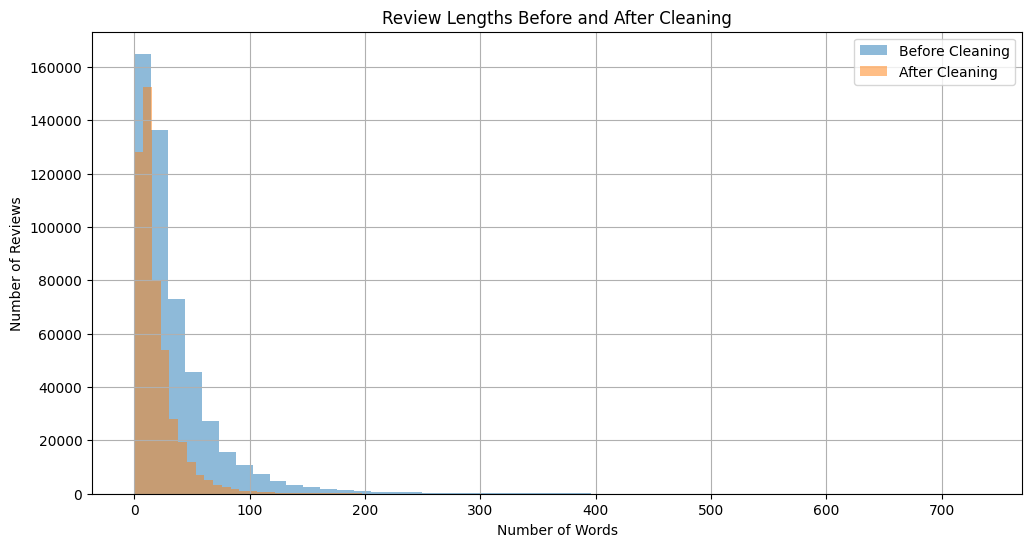

In [ ]:
#Plot histograms of review lengths
plt.figure(figsize=(12, 6))

plt.hist(df["len_before"], bins=50, alpha=0.5, label="Before Cleaning")
plt.hist(df["len_after"], bins=50, alpha=0.5, label="After Cleaning")

plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Review Lengths Before and After Cleaning")
plt.legend()
plt.grid(True)
plt.show()

We plot histograms showing the number of words before and after cleaning. This lets us see whether the cleaning drastically shortened the text and understand review length distribution (e.g., if we need to cap input length for neural networks later)
We can use this information to choose padding lengths and detect outliers.


In [ ]:
#Final train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Bad_reviews"]
)

We split the dataset into training (80%) and testing (20%) sets using stratified sampling based on the `Bad_reviews' label. We use stratify as it ensures both train and test sets preserve the same class balance (positive/negative).

The reason for splitting the data now is to avoid any data leakage by ensuring that all preprocessing or model training happens only on the training set.


In [ ]:
#Display sample output
train_df.head()

,reviews,Bad_reviews,Reviews_clean,len_before,len_after
85101,Quality and Convenience of location Ridiculo...,0,quality convenience location ridiculous not wi...,23,13
184222,very good hotel in a central locationsatisfie...,0,good hotel central locationsatisfied happy cho...,14,7
158312,Excellent value for the money The room was ...,1,excellent value money room warm even fan supplied,15,8
447977,Excellent food Beautiful rooms Excellent staff,0,excellent food beautiful room excellent staff,6,6
291385,Comfortable room Polite helpful staff,0,comfortable room polite helpful staff,5,5


In [ ]:
print("Shape of the training data:", train_df.shape)
print("Shape of the testing data:", test_df.shape)
print("\nFirst 5 rows of the training data:")
print(train_df.head())


Shape of the training data: (399396, 5)
Shape of the testing data: (99849, 5)

First 5 rows of the training data:
                                                  reviews  Bad_reviews  \
85101    Quality and Convenience of location  Ridiculo...            0   
184222   very good hotel in a central locationsatisfie...            0   
158312   Excellent value for the money   The room was ...            1   
447977    Excellent food Beautiful rooms Excellent staff             0   
291385            Comfortable room Polite helpful staff              0   

                                            Reviews_clean  len_before  \
85101   quality convenience location ridiculous not wi...          23   
184222  good hotel central locationsatisfied happy cho...          14   
158312  excellent value money room warm even fan supplied          15   
447977      excellent food beautiful room excellent staff           6   
291385              comfortable room polite helpful staff           5   

  

In [ ]:
print("\nInformation about the training data:")
print(train_df.info())
print("\nDescriptive statistics of the training data:")
print(train_df.describe())


Information about the training data:
<class 'pandas.core.frame.DataFrame'>
Index: 399396 entries, 85101 to 416262
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   reviews        399396 non-null  object
 1   Bad_reviews    399396 non-null  int64 
 2   Reviews_clean  399396 non-null  object
 3   len_before     399396 non-null  int64 
 4   len_after      399396 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.3+ MB
None

Descriptive statistics of the training data:
         Bad_reviews     len_before      len_after
count  399396.000000  399396.000000  399396.000000
mean        0.353181      34.641441      19.167616
std         0.477959      38.518226      19.151940
min         0.000000       0.000000       0.000000
25%         0.000000      11.000000       7.000000
50%         0.000000      23.000000      13.000000
75%         1.000000      44.000000      24.000000
max         1.000000     733.000000

In [ ]:
# TF-IDF Vectorization with bigrams
# Justification for limit: 10000 features allow capturing relevant patterns without excessive computation.
# With 10000, we reduce the chance of overfitting since this is a large dataset.
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Reviews_clean"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Reviews_clean"])

We use `TfidfVectorizer' to convert the cleaned review text into numerical feature vectors. Limiting the 'max-features' to 10000 to reduce memory issues and overfitting since this is a relatively large dataset and 10000 features allow capturing relevant patterns without excessive computation.
'ngram_range=(1, 2)' Includes both unigrams (single words) and bigrams (2-word combinations). Bigrams allow the model to learn important phrases like “not good” or “very clean”.



In [ ]:
y_train = train_df["Bad_reviews"]
y_test = test_df["Bad_reviews"]

We store the binary target values ('Bad_reviews) in 'y_train' and `y_test'.

This step keeps inputs ('X') and labels ('y') separate, which is standard practice for training and evaluation.


In [ ]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

We train a `LogisticRegression' model on the TF-IDF features.

The reason for choosing logistic regression as one of the models its because it’s a strong and interpretable baseline for binary classification. The model is fast to train, and handles high-dimensional text data well. And also works well when features are transformed with TF-IDF.

We increase `max_iter=1000' to ensure convergence, as text models often require more iterations.


In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
#    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression (TF-IDF)")

--- Logistic Regression (TF-IDF) Evaluation ---
Accuracy: 0.8100331500565855
Precision: 0.7623386239979395
Recall: 0.6714589536367503
Confusion Matrix:
[[57202  7382]
 [11586 23679]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     64584
           1       0.76      0.67      0.71     35265

    accuracy                           0.81     99849
   macro avg       0.80      0.78      0.79     99849
weighted avg       0.81      0.81      0.81     99849



We define a reusable `evaluate_model()' function to compute:
- Accuracy
- Precision
- Recall
- Confusion Matrix
- Classification Report

Precision is important here because we want to avoid falsely labeling positive reviews as negative (false positives). Recall ensures we don’t miss many bad reviews. And F1-score balances both
(spørsmål: hvorfor er f1-scre kommentert ut)

In [ ]:
# Train and Evaluate Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)")

--- Naive Bayes (TF-IDF) Evaluation ---
Accuracy: 0.7946899818726276
Precision: 0.7416134838815251
Recall: 0.6425634481780802
Confusion Matrix:
[[56689  7895]
 [12605 22660]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     64584
           1       0.74      0.64      0.69     35265

    accuracy                           0.79     99849
   macro avg       0.78      0.76      0.77     99849
weighted avg       0.79      0.79      0.79     99849



We train a `MultinomialNB' model using the same TF-IDF features.

The reason for choosing a Naive Bayes Model is because its widely used for text classification tasks. Very fast and efficient for high-dimensional sparse data like TF-IDF. And often performs surprisingly well as a baseline.

Evaluation helps us compare performance against Logistic Regression.


In [ ]:
# Train and Evaluate Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) #Max depth added to cap training time and to avoid overfitting.
# Based on previous evaluation, deeper trees (e.g., 30) overfit and reduce recall significantly
dt_model.fit(X_train_tfidf, y_train)
evaluate_model(dt_model, X_test_tfidf, y_test, "Decision Tree (TF-IDF)")

--- Decision Tree (TF-IDF) Evaluation ---
Accuracy: 0.7212190407515349
Precision: 0.6617743129654632
Recall: 0.43088047639302424
F1 Score: 0.5219317830522447
Confusion Matrix:
[[56818  7766]
 [20070 15195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     64584
           1       0.66      0.43      0.52     35265

    accuracy                           0.72     99849
   macro avg       0.70      0.66      0.66     99849
weighted avg       0.71      0.72      0.70     99849



We train a 'DecisionTreeClassifier' with a 'max_depth=10'. Max depth was limited to 10 because deeper trees can overfit easily, especially with sparse, high-dimensional data. During tuning, deeper trees reduced recall, so this cap balances generalization and training time.

Decision trees also offer interpretability, though they often underperform compared to ensemble models on text.


In [ ]:
# LSTM Model Training
max_vocab = 10000    # Limit to top 10,000 most frequent tokens to reduce memory & overfitting
max_len = 100        # Pad/truncate reviews to 100 tokens for consistent input shape
embedding_dim = 100  # 100-dim word embeddings balance expressiveness and efficiency

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>") # Use top 10k words; mark unknown words as <OOV>
tokenizer.fit_on_texts(train_df["Reviews_clean"])             # Build word index from training reviews only

We use a `Tokenizer' from Keras to convert text into integer sequences.
Parameters:
- `num_words=10000': Only keep the 10,000 most frequent words to reduce memory usage and prevent overfitting.
- `oov_token="<OOV>"': Any word not seen during training will be replaced with this token, preventing crashes from unseen test-time tokens.

we have to do these steps because Neural networks (like LSTMs) can't process raw text. They require fixed-length sequences of integers representing word indices.

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(train_df["Reviews_clean"])   # Convert words to integer sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["Reviews_clean"])     # Apply same tokenizer to test data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # Pad/truncate to length 100
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

We transform the tokenized sequences to have equal length using `pad_sequences()':

- `maxlen=100': All reviews are padded or truncated to 100 tokens.
- 'padding='post'', `truncating='post'': Ensures that beginning of the sentence remains intact.

the reason for picking 100 tokens:
A histogram of review lengths showed that most cleaned reviews are under 100 words. So, 100 balances:
- Enough context for the model
- Computational efficiency

In [ ]:
# Build and Train LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim),# Word embeddings
    LSTM(64, return_sequences=False),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid') # Binary classification output
])

We define a `Sequential' model using the following layers:

`Embedding':
Maps each word to a dense vector of size 100. This helps the model understand word similarity. - `input_dim=10000' limit the vocabulary to the top 10,000 most frequent words in the training data. It captures enough variety without making the model too large or slow. This is a common choice in NLP tasks to balance memory and performance. 'output_dim=100' makes each word mapped to a 100-dimensional dense vector (embedding). it's a popular and effective size for capturing semantic meaning without requiring excessive computation. Pre-trained embeddings like GloVe often use 50, 100, 200, or 300 dimensions.

`LSTM(64)':
Captures sequential word patterns and long-range dependencies.`64' is the number of memory units (or neurons) in the LSTM layer. It's a moderate size — large enough to learn patterns over sequences, but not so large that it overfits quickly or trains too slowly. More units = more memory and complexity, but also more risk of overfitting.

`Dropout(0.5)':
Reduces overfitting by randomly dropping 50% of neurons during training.`0.5' means that 50% of the neurons are randomly "dropped out" during training. Dropout helps prevent overfitting by forcing the model to not rely too much on any one feature. 0.5 is a standard and relatively strong dropout rate, often used in text models.

`Dense(1, activation='sigmoid')':
Outputs a probability score for binary classification. `1' The output layer has one neuron because we are solving a binary classification task (bad review or not). The activation function 'sigmoid' squashes the output to a value between 0 and 1 — representing a probability.




LSTM (Long Short-Term Memory) networks are great at modeling language and capturing contextual meaning across words in a sequence.



In [ ]:
# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, max_len)) # Manually build the model with input shape: batch x sequence_length
lstm_model.summary()                          # Now shows actual layer sizes & parameter counts

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Evaluate LSTM Model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0) # Evaluate loss & accuracy on test set
print("--- LSTM (Word Embeddings) Evaluation ---")
print("Accuracy:", lstm_acc)
y_pred_lstm_prob = lstm_model.predict(X_test_pad)                        # Get predicted probabilities
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)                       # Convert to binary predictions (threshold = 0.5)
print("Precision:", precision_score(y_test, y_pred_lstm))
print("Recall:", recall_score(y_test, y_pred_lstm))
print("F1 Score:", f1_score(y_test, y_pred_lstm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm))

--- LSTM (Word Embeddings) Evaluation ---
Accuracy: 0.6476880311965942
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Precision: 0.5908141962421712
Recall: 0.008024953920317596
F1 Score: 0.015834825425246196
Confusion Matrix:
[[64388   196]
 [34982   283]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     64584
           1       0.59      0.01      0.02     35265

    accuracy                           0.65     99849
   macro avg       0.62      0.50      0.40     99849
weighted avg       0.63      0.65      0.51     99849



We evaluate the LSTM on the test set using both accuracy and classification metrics:

- Use a threshold of `0.5' on predicted probabilities to classify each review.
- Compute Precision, Recall, F1-score, and Confusion Matrix — just like with traditional models.

Evaluating this way ensures a fair comparison between the LSTM model and the earlier models (Logistic Regression, Naive Bayes, etc.).
Neural models typically outperform simpler ones when trained properly — but we need clear metrics to support that.
